In [ ]:
#@markdown ### Colab 노트북 Dependency 설치하기
#@markdown - Colab 노트북을 사용하는데 필요한 Packages를 설치합니다.
#@markdown ---

from IPython.display import clear_output
import ipywidgets as widgets

def inf(msg, style, wdth): 
    inf = widgets.Button(description=msg, disabled=True, button_style=style, layout=widgets.Layout(min_width=wdth));display(inf)
    
C_default = "\033[0;39m"
C_yellow = "\033[1;93m"

print(C_yellow + "Install..." + C_default)
# START

!pip install gdown==v4.6.3

# END CODE
clear_output()
inf('\u2714 Done', 'success', '50px')

Button(button_style='success', description='✔ Done', disabled=True, layout=Layout(min_width='50px'), style=But…

In [ ]:
#@markdown ### DBNet Resources 다운로드 (Google Drive)

#@markdown 미리 준비된 다음 파일을 설정한 경로에 다운로드 받습니다.
#@markdown - Model checkpoint
#@markdown - requirements.txt
#@markdown ---

print(C_yellow + "Download..." + C_default)
# START

GDrive_URL = "https://drive.google.com/drive/folders/1TYvjiTivRJcIrLytshcEaaooLie9s4pU?usp=sharing" #@param {type:"string"}
Download_Path = "/content/DB" #@param {type:"string"}

!mkdir -p {Download_Path}
!gdown {GDrive_URL} -O {Download_Path} --folder

print(C_yellow + "Install..." + C_default)
!pip install -r {Download_Path}/requirements.txt

# END CODE
clear_output()
inf('\u2714 Done', 'success', '50px')

Button(button_style='success', description='✔ Done', disabled=True, layout=Layout(min_width='50px'), style=But…

In [ ]:
#@title 패키지 임포트
import os
import sys
import math
import numpy as np
from collections import OrderedDict
from itertools import accumulate

# PyTorch Model 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import timm

# Image Processing 및 Visualization 관련
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from shapely.geometry import Polygon
import pyclipper
from tqdm import tqdm
import matplotlib.pyplot as plt

## 2. DBNet 모델 구현체 알아보기

```
💡 목차 개요: DBNet 모델을 구성하는 각 부분의 구조에 대해서 알아본다.
```
1. Encoder
 - 이미지에서 다양한 Scale로 Feature를 추출하는 단계
 - Timm Pretrained Backbone model : [Timm](https://timm.fast.ai/)

2. Decoder
 - Encoder 에서 추출된 Feature를 결합하여 텍스트 영역 정보로 복원하는 단계
 - UNet 구조

3. Head
 - 복원된 텍스트 영역 정보를 바탕으로 텍스트 영역의 경계를 예측하는 단계
 - Probability map
   : 텍스트 영역에 대한 Segmentation map
 - Threshold map
   : Probability map의 각 픽셀에 대한 이진화 임계값

In [ ]:
#@title DBNet Encoder (Timm Resnet-18)

### Pretrained Backnone model
class TimmBackbone(nn.Module):
    def __init__(self, model_name='resnet18',    # Timm 백본 모델 선택
                 select_features=[1, 2, 3, 4],   # UNet과 연결한 Feature Layer지정
                 pretrained=True):
        super(TimmBackbone, self).__init__()

        # Timm 라이브러리를 사용하여 사전 훈련된 백본 모델을 불러오기
        self.model = timm.create_model(model_name, pretrained=pretrained, features_only=True)

        # Decoder에 연결하려는 Feature를 선택
        self.select_features = select_features

    def forward(self, x):
        features = self.model(x)

        # 백본 모델의 선택된 Feature Embeddings만 반환
        return [features[i] for i in self.select_features]

In [ ]:
#@title DBNet Encoder의 Shape 확인

dummy_input = torch.randn((1, 3, 640, 640), dtype=torch.float32)  # 입력 크기를 640 * 640 으로 가정할 때

encoder = TimmBackbone()
encoder_outs = encoder(dummy_input)
for idx, out in enumerate(encoder_outs):
    print(f"{idx}: {out.shape}")             # 백본 Shape을 주의깊게 살펴봅니다.

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

0: torch.Size([1, 64, 160, 160])
1: torch.Size([1, 128, 80, 80])
2: torch.Size([1, 256, 40, 40])
3: torch.Size([1, 512, 20, 20])


### DBNet의 Decoder (UNet) 구조

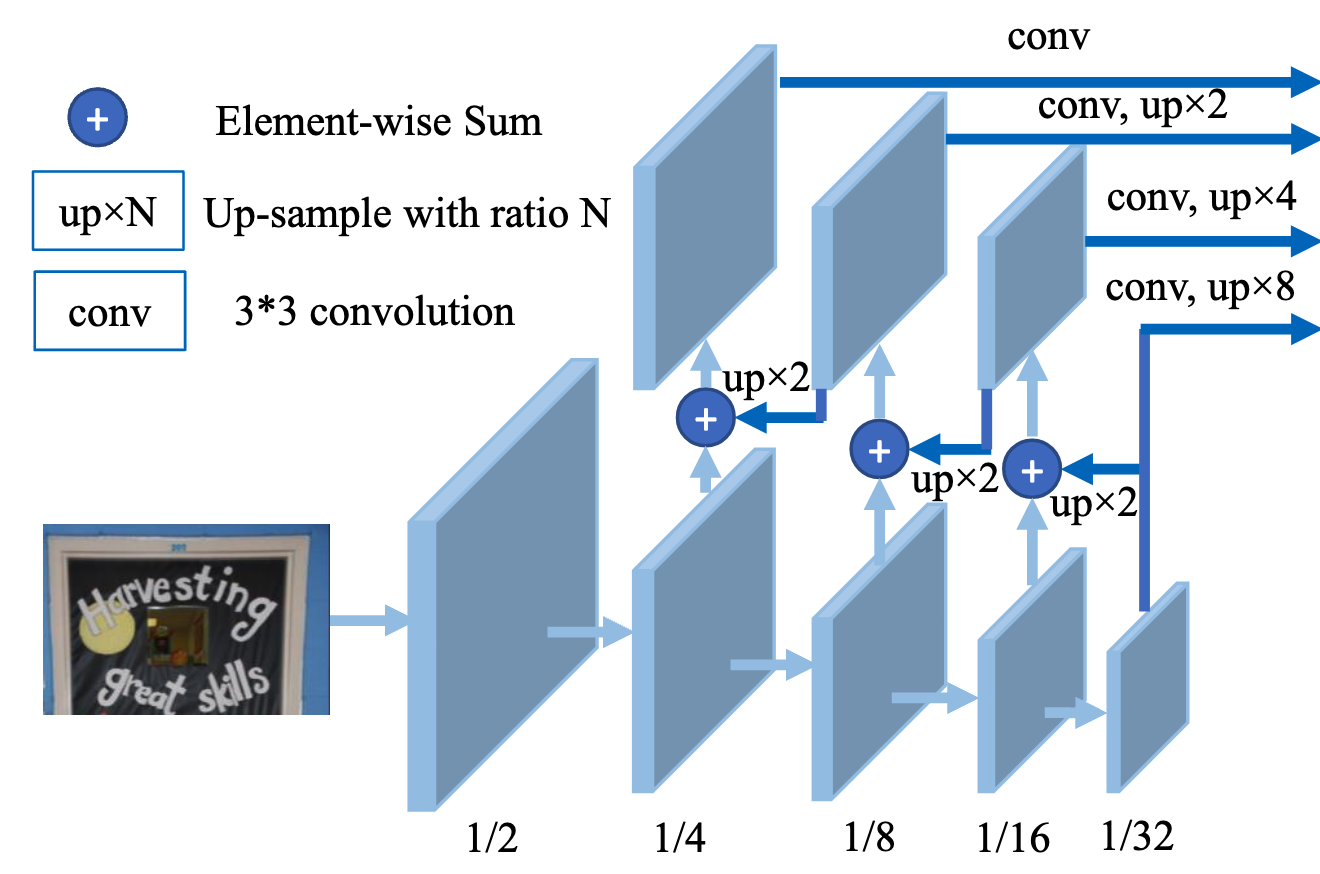

In [ ]:
#@title DBNet Decoder (UNet)

class UNet(nn.Module):
    def __init__(self,
                 in_channels=[64, 128, 256, 512],  # Encoder의 Feature Channels와 일치
                 strides=[4, 8, 16, 32],           # Decoder Scale Factors
                 inner_channels=256,               # Decoder Inner channels (Hidden layer channels)
                 output_channels=64,               # Decoder Output channels
                 bias=False):
        super(UNet, self).__init__()

        assert len(strides) == len(in_channels), "Mismatch in 'strides' and 'in_channels' lengths."

        # Parameters에 따라 UNet 구조를 동적으로 생성
        # Decoder size 계산
        # UNet 구조의 구현체로서, Width, Height가 줄어든만큼 크기를 복원하기 위한 ratio 변수
        upscale_factors = [strides[idx] // strides[idx - 1] for idx in range(1, len(strides))]
        outscale_factors = list(accumulate(upscale_factors, lambda x, y: x * y))

        # Up-sample 구조를 위한 Layers를 생성 : 각 층의 차이만큼 Feature를 확대
        self.upsamples = nn.ModuleList()
        for upscale in upscale_factors:
            self.upsamples.append(nn.Upsample(scale_factor=upscale, mode='nearest'))

        # Encoder와 Decoder를 연결하는 Skip connection layers를 생성
        self.inners = nn.ModuleList()
        for in_channel in in_channels:
            self.inners.append(nn.Conv2d(in_channel, inner_channels, kernel_size=1, bias=bias))

        # 각 층의 결과를 출력하는 layers를 생성: outscale_factors에 따라 width, height를 확대
        self.outers = nn.ModuleList()
        for outscale in reversed(outscale_factors):
            outer = nn.Sequential(nn.Conv2d(inner_channels, output_channels,
                                            kernel_size=3, padding=1, bias=bias),
                                  nn.Upsample(scale_factor=outscale, mode='nearest'))
            self.outers.append(outer)
        self.outers.append(nn.Conv2d(inner_channels, output_channels, kernel_size=3,
                                     padding=1, bias=bias))

        # Weight 초기화
        self.upsamples.apply(self.weights_init)
        self.inners.apply(self.weights_init)
        self.outers.apply(self.weights_init)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight.data)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.fill_(1.)
            m.bias.data.fill_(1e-4)

    def forward(self, features):
        # Encoder의 Feature embeddings를 각각 입력
        in_features = [inner(feat) for feat, inner in zip(features, self.inners)]

        # Upsample
        up_features = []
        up = in_features[-1]
        for i in range(len(in_features) - 1, 0, -1):
            up = self.upsamples[i - 1](up) + in_features[i - 1]
            up_features.append(up)

        # UNet Output
        out_features = [self.outers[0](in_features[-1])]
        out_features += [outer(feat) for feat, outer in zip(up_features, self.outers[1:])]

        return out_features


In [ ]:
#@title DBNet Decoder의 Shape 확인

decoder = UNet()
decoder_outs = decoder(encoder_outs)
for idx, out in enumerate(decoder_outs):
    print(f"{idx}: {out.shape}")             # Decoder Shape을 주의깊게 살펴봅니다.
                                             # DBNet 기본 구조를 살펴보면, 입력 이미지의 1/4 크기로 출력을 구함

0: torch.Size([1, 64, 160, 160])
1: torch.Size([1, 64, 160, 160])
2: torch.Size([1, 64, 160, 160])
3: torch.Size([1, 64, 160, 160])


In [ ]:
#@title DBNet Head 모델

class DBHead(nn.Module):
    def __init__(self, in_channels=256,       # Decoder의 Output Channels와 일치 (decoder의 outputs를 concat)
                       upscale=4,             # Decoder의 Output을 입력 Image의 사이즈에 맞게 확대
                       k=50,                  # DB Step Function에서 사용하는 Amplifying factor
                       bias=False,
                       smooth=False):
        super(DBHead, self).__init__()

        self.in_channels = in_channels
        self.inner_channels = in_channels // 4
        self.k = k

        # Feature embedding을 Upscale에 따라 확장: Upscale에 필요한 Layer Depth를 계산
        self.upscale = int(math.log2(upscale))

        # Probability map
        # Upscale에 따라 ConvTranspose2d Layer를 동적으로 생성
        # ex) ConvTranspose2d → BatchNorm2d → ReLU → ... → ConvTranspose2d → Sigmoid
        binarize_layers = [nn.Conv2d(self.in_channels, self.inner_channels, kernel_size=3,
                                     padding=1, bias=bias),
                           nn.BatchNorm2d(self.inner_channels),
                           nn.ReLU(inplace=True)]
        for i in range(self.upscale):
            if i == self.upscale - 1:
                binarize_layers.append(
                    nn.ConvTranspose2d(self.inner_channels, 1, 2, 2)
                )
            else:
                binarize_layers.append(nn.ConvTranspose2d(self.inner_channels,
                                                          self.inner_channels, 2, 2))
                binarize_layers.append(nn.BatchNorm2d(self.inner_channels))
                binarize_layers.append(nn.ReLU(inplace=True))
        binarize_layers.append(nn.Sigmoid())
        self.binarize = nn.Sequential(*binarize_layers)

        # Threshold map
        self.thresh = self._init_thresh(smooth=smooth, bias=bias)

        # Weight 초기화
        self.binarize.apply(self.weights_init)
        self.thresh.apply(self.weights_init)

    def _init_thresh(self, smooth=False, bias=False):
        # Upscale에 따라 Upsample Layer를 동적으로 생성
        # ex) ConvTranspose2d → BatchNorm2d → ReLU → ... → ConvTranspose2d → Sigmoid
        # Smooth 가 True인 경우, Threshold map 결과의 모눈 현상을 감소시키기 위하여 Upsample을 사용
        thresh_layers = [nn.Conv2d(self.in_channels, self.inner_channels, kernel_size=3,
                                   padding=1, bias=bias),
                         nn.BatchNorm2d(self.inner_channels),
                         nn.ReLU(inplace=True)]
        for i in range(self.upscale):
            if i == self.upscale - 1:
                thresh_layers.append(self._init_upsample(self.inner_channels, out_channels=1,
                                                         smooth=smooth, bias=bias))
            else:
                thresh_layers.append(self._init_upsample(self.inner_channels, self.inner_channels,
                                                         smooth=smooth, bias=bias))
                thresh_layers.append(nn.BatchNorm2d(self.inner_channels))
                thresh_layers.append(nn.ReLU(inplace=True))
        thresh_layers.append(nn.Sigmoid())
        thresh = nn.Sequential(*thresh_layers)

        return thresh

    def _init_upsample(self, in_channels, out_channels, smooth=False, bias=False):
        # Smooth 가 True인 경우, ConvTranspose2d 대신 Upsample을 사용
        if smooth:
            inter_out_channels = out_channels
            if out_channels == 1:
                inter_out_channels = in_channels
            module_list = [
                    nn.Upsample(scale_factor=2, mode='nearest'),
                    nn.Conv2d(in_channels, inter_out_channels, 3, padding=1, bias=bias)]
            if out_channels == 1:
                module_list.append(
                    nn.Conv2d(in_channels, out_channels,
                              kernel_size=1, stride=1, padding=0, bias=True))
            return nn.Sequential(*module_list)
        else:
            return nn.ConvTranspose2d(in_channels, out_channels, 2, 2)

    def _step_function(self, x, y):
        # Probability map과 Thresholdmap을 이용하여 Approximate Binary Map 생성
        return torch.reciprocal(1 + torch.exp(-self.k * (x - y)))

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight.data)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.fill_(1.)
            m.bias.data.fill_(1e-4)

    def forward(self, features, return_loss=True):
        # Input feature concat
        fuse = torch.cat(features, dim=1)

        # Probability map
        binary = self.binarize(fuse)

        # 모델 학습 단계에서만 Threshold map을 계산
        # 추론 단계에서는 Probability map을 Binarization map으로 사용 (학습된 모델에서는 결과의 차이가 거의 없음)
        if return_loss:
            # Threshold map
            thresh = self.thresh(fuse)

            # Approximate Binary map
            thresh_binary = self._step_function(binary, thresh)
            result = OrderedDict(prob_maps=binary, thresh_maps=thresh, binary_maps=thresh_binary)
        else:
            # Probability map only - Inference mode
            result = OrderedDict(prob_maps=binary)

        return result

In [ ]:
#@title DBNet Model Architecture

class OCRModel(nn.Module):
    def __init__(self):
        super(OCRModel, self).__init__()

        # 각 모듈 instantiate
        self.encoder = TimmBackbone()
        self.decoder = UNet()
        self.head = DBHead()

    def forward(self, images, return_loss=True, **kwargs):
        # 모델 추론
        encoded_features = self.encoder(images)
        decoded_features = self.decoder(encoded_features)
        pred = self.head(decoded_features, return_loss)
        return pred

## 2. DBNet 모델 추론과정 알아보기

```
💡 목차 개요: 구현한 DBNet 모델로 영수증 이미지를 추론해보고, 후처리를 거쳐 텍스트 영역을 검출하는 과정을 알아본다.
```
1. 모델 선언 및 Weight 불러오기

2. 데이터 전처리 및 모델 추론

3. 추론 결과 후처리 및 시각화

In [ ]:
#@title 모델 선언 및 Weight 불러오기

# Model architecture 선언
device = torch.device("cuda")
model = OCRModel().to(device)

# Load pretrained model weight
Model_Path = Download_Path + '/dbnet-receipt.ckpt'
if not os.path.exists(Model_Path):
    print("Checkpoint not found: " + Model_Path)

states = torch.load(Model_Path, map_location=device)
model.load_state_dict(states, strict=True)

model.eval()
# 모델 구조 출력

OCRModel(
  (encoder): TimmBackbone(
    (model): FeatureListNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (c

In [ ]:
#@markdown ### DBNet Inference Test 이미지 다운로드 (Google Drive)
#@markdown ---

print(C_yellow + "Download..." + C_default)
# START

GDrive_URL = "https://drive.google.com/drive/folders/1FBEafD3Zua86kb5TodVUgAk5SgRuIUJ4?usp=drive_link" #@param {type:"string"}
Dataset_Path = "/content/Dataset" #@param {type:"string"}

!mkdir -p {Dataset_Path}
!gdown {GDrive_URL} -O {Dataset_Path} --folder

# END CODE
clear_output()
inf('\u2714 Done', 'success', '50px')

Button(button_style='success', description='✔ Done', disabled=True, layout=Layout(min_width='50px'), style=But…

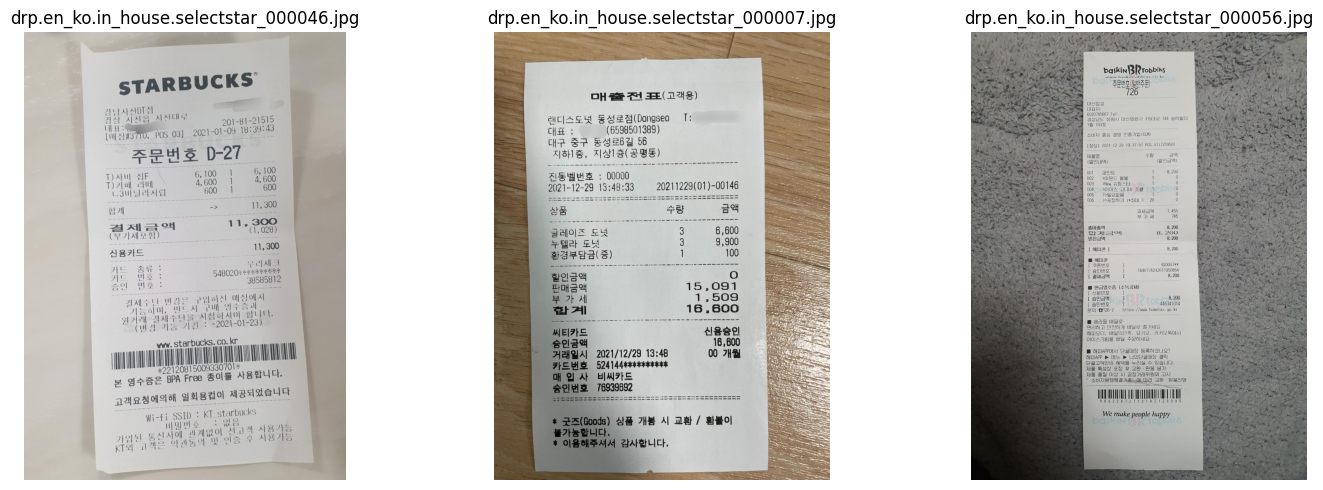

In [ ]:
#@title 테스트 이미지 시각화

folder_path = os.path.join(Dataset_Path, 'images/test')

# 폴더에서 이미지 파일 목록 가져오기 (JPEG 및 PNG 파일만)
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# 이미지 수에 따라 행의 수 계산
n_rows = len(image_files) // 3 + int(len(image_files) % 3 > 0)

# 이미지 표시
test_images = []
plt.figure(figsize=(15, 5 * n_rows))
for i, file in enumerate(image_files):
    img_path = os.path.join(folder_path, file)

    # OpenCV를 사용하여 이미지 로드
    img = cv2.imread(img_path)
    test_images.append(img)

    # BGR에서 RGB로 변환
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(n_rows, 3, i + 1)
    plt.imshow(img)
    plt.title(file)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#@title DBNet 데이터 전처리

# Albumentations 변환 정의 : 입력 사이즈 변환 및 Padding, Normalize, Tensor변환
transform = A.Compose([
    A.LongestMaxSize(max_size=640, p=1.0),
    A.PadIfNeeded(min_width=640, min_height=640, border_mode=0, p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


# 줄어든 이미지 사이즈를 입력 이미지 사이즈로 복원하기 위한 Inverse Matrix를 계산
def calculate_inverse_transform(original_size, transformed_size, crop_box=None):
    ox, oy = original_size
    tx, ty = transformed_size
    cx, cy = 0, 0
    if crop_box:
        cx, cy, tx, ty = crop_box

    # Scale back to the original size
    scale_x = ox / tx
    scale_y = oy / ty
    scale_matrix = np.array([
        [scale_x, 0, 0],
        [0, scale_y, 0],
        [0, 0, 1]
    ])

    # Padding back to the original size
    translation_matrix = np.eye(3)
    translation_matrix[0, 2] = -cx
    translation_matrix[1, 2] = -cy

    # 하나의 매트릭스로 역변환 할 수 있도록 두 매트릭스를 결합
    inverse_matrix = np.dot(scale_matrix, translation_matrix)
    return inverse_matrix


# 변환된 이미지의 Size 및 Padding 크기 계산
def calculate_cropbox(original_size, target_size=640):
    ox, oy = original_size
    scale = target_size / max(ox, oy)
    new_width, new_height = int(ox * scale), int(oy * scale)
    delta_w = target_size - new_width
    delta_h = target_size - new_height
    x, y = delta_w // 2, delta_h // 2
    w, h = new_width, new_height
    return x, y, w, h


# 테스트 이미지 준비 과정
batch = []
for image in test_images:
    data = dict()
    transformed = transform(image=image)                        # 이미지 Transform
    transformed_image = transformed["image"]
    data['images'] = transformed_image.unsqueeze(0).to(device)  # 모델 추론을 위한 변환된 이미지 저장
    data['origin_images'] = [image]                             # Visualization을 위한 원본 이미지 저장

    # 추론 결과를 원본 이미지 크기로 변환하기 위한 Inverse Matrix 저장
    height, width, _ = image.shape
    _, new_height, new_width = transformed_image.shape
    crop_box = calculate_cropbox((width, height), max(new_height, new_width))
    inverse_matrix = calculate_inverse_transform((width, height),
                                                 (new_width, new_height),
                                                 crop_box=crop_box)
    data['inverse_matrix'] = [inverse_matrix]

    batch.append(data)

In [ ]:
#@title DBNet 모델 추론

preds = []
for data in tqdm(batch):
    # 일반적인 추론 과정에서는 Threshold map을 생략하지만, 실습 예제에서는 Threshold map 시각화를 위해 사용
    # preds.append(model(data['images'], return_loss=False)  # 일반적인 추론 과정
    preds.append(model(data['images']))

100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


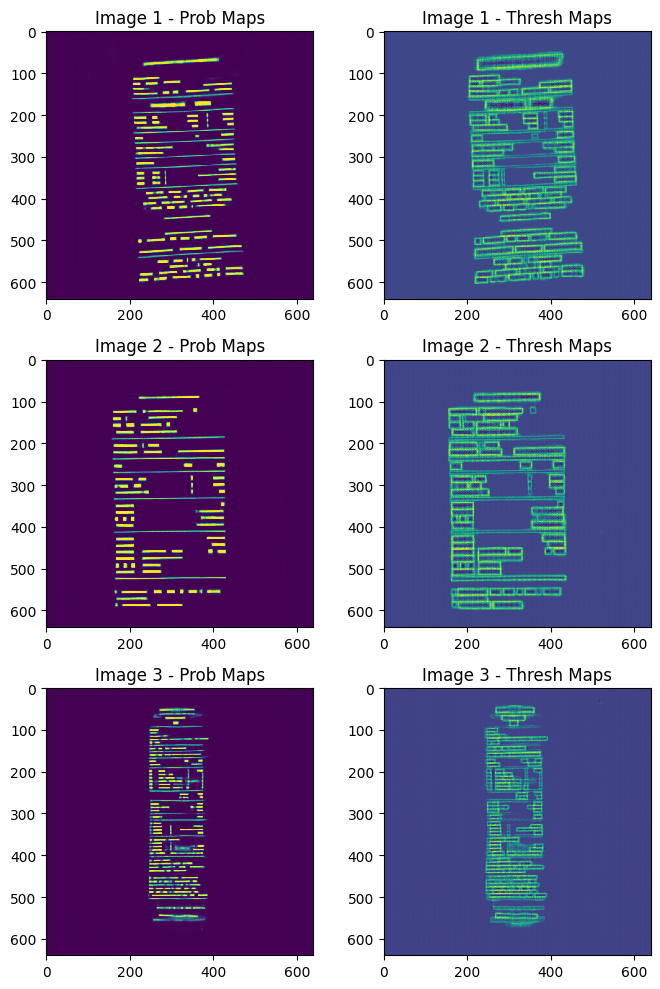

In [ ]:
#@title DBNet 모델 추론 결과 시각화

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7, 10))

for i, output in enumerate(preds):
    prob_maps = output['prob_maps'].squeeze(0).detach().cpu().squeeze(0)
    thresh_maps = output['thresh_maps'].squeeze(0).detach().cpu().squeeze(0)

    axes[i, 0].imshow(prob_maps, cmap='viridis', interpolation='nearest')
    axes[i, 0].set_title(f'Image {i+1} - Prob Maps')

    axes[i, 1].imshow(thresh_maps, cmap='viridis', interpolation='nearest')
    axes[i, 1].set_title(f'Image {i+1} - Thresh Maps')

plt.tight_layout()
plt.show()

In [ ]:
#@title 추론 결과 후처리를 위한 Class

class DBPostProcessor:
    def __init__(self, thresh=0.3, box_thresh=0.4, max_candidates=300, use_polygon=False):
        self.min_size = 3                       # 텍스트 검출 최소 사이즈
        self.thresh = thresh                    # 모델의 출력 결과 Segmentation map을 Binarization 하기 위한 Threshold
        self.box_thresh = box_thresh            # 텍스트 영역 판정을 위한 Threshold
        self.max_candidates = max_candidates    # 최대 텍스트 검출 후보 영역의 갯수
        self.use_polygon = use_polygon          # Polygon 검출을 할지 Quad 검출을 할지에 대한 Type flag

    # Segmentation map 결과로부터 텍스트 영역의 좌표를 반환하는 메소드
    def represent(self, batch, _pred):
        """
        batch: a dict produced by dataloaders.
            images: tensor of shape (N, C, H, W).
            polygons: tensor of shape (N, K, 4, 2), the polygons of objective regions.
            ignore_tags: tensor of shape (N, K), indicates whether a region is ignorable or not.
            shape: the original shape of images.
            inverse_matrix: Warp Perspective Matrix, with shape (3, 3) as NDArray[float32]
            filename: the original filenames of images.
        pred:
            prob_maps: text region segmentation map, with shape (N, 1, H, W)
        """
        assert 'images' in batch is not None, "images is required in batch"
        images = batch['images']

        # Use prob_maps if pred is a dict
        if isinstance(_pred, dict):
            assert 'prob_maps' in _pred is not None, "prob_maps is required in _pred"
            pred = _pred['prob_maps']
        else:
            pred = _pred

        assert 'inverse_matrix' in batch is not None, "inverse_matrix is required in batch"
        inverse_matrix = batch['inverse_matrix']

        # Probability map을 이진화
        segmentation = self.binarize(pred)

        boxes_batch = []
        scores_batch = []
        for batch_index in range(images.size(0)):
            if self.use_polygon:
                # Get polygons from segmentation
                boxes, scores = self.polygons_from_bitmap(
                                        pred[batch_index],
                                        segmentation[batch_index],
                                        inverse_matrix=inverse_matrix[batch_index])
            else:
                # Get boxes from segmentation
                boxes, scores = self.boxes_from_bitmap(
                                        pred[batch_index],
                                        segmentation[batch_index],
                                        inverse_matrix=inverse_matrix[batch_index])
            # Append to batch
            boxes_batch.append(boxes)
            scores_batch.append(scores)

        return boxes_batch, scores_batch

    @staticmethod
    # Inverse matrix를 이용하여 원본 이미지에 대한 좌표로 변환 하는 메소드
    def __transform_coordinates(coords, matrix):
        """
        Transform coordinates according to the warp matrix

        coords: (N, 2) as NDArray[float32]
        matrix: (3, 3) as NDArray[float32]
        return: (N, 2) as NDArray[float32]
        """
        coords = np.array(coords)
        coords = np.dot(matrix, np.vstack([coords.T, np.ones(coords.shape[0])]))
        coords /= coords[2, :]
        return coords.T[:, :2]

    # Binarize the prediction
    def binarize(self, pred):
        # 후처리 과정에서 단일 Threshold를 사용하여 이진화
        return pred > torch.Tensor([self.thresh]).to(device=pred.device)

    # 추론 결과 영역에서 텍스트 영역을 검출하여 반환하는 메소드 (Polygon으로 추출할때)
    def polygons_from_bitmap(self, pred, _bitmap,
                             inverse_matrix=None):
        """
        Extracts polygons and their scores from a bitmap image.

        _bitmap: single map with shape (1, H, W),
            whose values are binarized as {0, 1}
        """

        assert _bitmap.size(0) == 1
        bitmap = _bitmap.cpu().numpy()[0]  # The first channel
        pred = pred.cpu().detach().numpy()[0]

        boxes = []
        scores = []

        # 컨투어 영역 찾기
        # Find contours from the binarized map
        # contours: a list of contours
        # https://docs.opencv.org/4.9.0/d4/d73/tutorial_py_contours_begin.html
        contours, _ = cv2.findContours(
            (bitmap * 255).astype(np.uint8),
            cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        # 최대 텍스트 검출 후보 영역의 갯수만큼 컨투어 영역이 텍스트 영역인지 판단
        # Get the top N contours
        for contour in contours[:self.max_candidates]:
            # 복잡한 컨투어 픽셀을 근사화하여 영역 다듬기
            # Approximate the contour with Douglas-Peucker algorithm
            # https://docs.opencv.org/4.9.0/dc/dcf/tutorial_js_contour_features.html
            epsilon = 0.002 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            points = approx.reshape((-1, 2))
            # 최소 포인트가 4개 미만인 경우 무시
            if points.shape[0] < 4:
                continue

            # 컨투어 영역에서 텍스트가 차지하는 영역에 대한 점수 계산
            # Get the score of the box
            score = self.box_score_fast(pred, points.reshape(-1, 2))
            if self.box_thresh > score:
                continue

            # Shrink되어있는 추론 결과를 다시 Dilate하는 과정
            # Unclip the box
            if points.shape[0] > 2:
                box = self.unclip(points, unclip_ratio=2.0)
                if box is None:
                    continue
            else:
                continue

            # 주어진 영역의 크기를 구하고 최소 사이즈 미만의 경우 무시
            # Get the mini box
            box = box.reshape(-1, 2)
            _, sside = self.get_mini_boxes(box.reshape((-1, 1, 2)))
            if sside < self.min_size + 2:
                continue

            # Inverse Matrix를 이용하여 원본 이미지의 위치로 좌표 변환
            # Transform the coordinates
            box = self.__transform_coordinates(box, inverse_matrix)

            # Append to the list
            boxes.append(np.round(box).astype(np.int16).tolist())
            scores.append(score)

        return boxes, scores

    # 추론 결과 영역에서 텍스트 영역을 검출하여 반환하는 메소드 (QuadBox로 추출할때)
    # 텍스트 영역을 찾는 과정을 제외하고 Polygon과 동일
    def boxes_from_bitmap(self, pred, _bitmap,
                          inverse_matrix=None):
        """
        Extracts bounding boxes and their scores from a bitmap image.

        _bitmap: single map with shape (1, H, W),
            whose values are binarized as {0, 1}
        """

        assert _bitmap.size(0) == 1
        bitmap = _bitmap.cpu().numpy()[0]  # The first channel
        pred = pred.cpu().detach().numpy()[0]

        boxes = []
        scores = []

        # 컨투어 영역 찾기
        # Find contours from the binarized map
        # contours: a list of contours
        # https://docs.opencv.org/4.9.0/d4/d73/tutorial_py_contours_begin.html
        contours, _ = cv2.findContours(
            (bitmap * 255).astype(np.uint8),
            cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        num_contours = min(len(contours), self.max_candidates)

        # 최대 텍스트 검출 후보 영역의 갯수만큼 컨투어 영역이 텍스트 영역인지 판단
        # Get the top N contours
        for index in range(num_contours):
            # 컨투어 영역의 좌표와 크기를 구하고 최소 사이즈 이하의 경우 무시
            # Get the mini box
            contour = contours[index]
            points, sside = self.get_mini_boxes(contour)
            if sside < self.min_size:
                continue

            # 컨투어 영역에서 텍스트가 차지하는 영역에 대한 점수 계산
            # Get the score of the box
            points = np.array(points)
            score = self.box_score_fast(pred, points.reshape(-1, 2))
            if self.box_thresh > score:
                continue

            # Shrink되어있는 추론 결과를 다시 Dilate하는 과정
            # Unclip the box
            box = self.unclip(points).reshape(-1, 1, 2)
            box, sside = self.get_mini_boxes(box)
            if sside < self.min_size + 2:
                continue
            box = np.array(box)

            # Inverse Matrix를 이용하여 원본 이미지의 위치로 좌표 변환
            # Transform the coordinates
            box = self.__transform_coordinates(box, inverse_matrix)

            # Append to the list
            boxes.append(np.round(box).astype(np.int16).tolist())
            scores.append(score)

        return boxes, scores

    def unclip(self, box, unclip_ratio=1.5):
        """
        Expands the given box by a specified ratio.

        box: a list of points of shape (N, 2)
        unclip_ratio: the ratio of unclipping the box
        return: a list of points of shape (N, 2)
        """

        # transform the box to polygon
        poly = Polygon(box)
        if poly.area == 0 or poly.length == 0:
            return None

        # get the expanded polygon
        # unclip_ratio의 비율로 확대된 Distance를 구하고 영역을 확장함
        distance = poly.area * unclip_ratio / poly.length
        offset = pyclipper.PyclipperOffset()
        offset.AddPath(box, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        expanded = np.array(offset.Execute(distance)[0])

        return expanded

    def get_mini_boxes(self, contour):
        """
        Converts a contour into its minimum area bounding box.

        contour: a list of points of shape (N, 1, 2)
        return: a list of points of shape (N, 2)
        """

        # Get the bounding box
        # https://docs.opencv.org/4.9.0/de/d62/tutorial_bounding_rotated_ellipses.html
        bounding_box = cv2.minAreaRect(contour)
        points = sorted(list(cv2.boxPoints(bounding_box)), key=lambda x: x[0])

        index_1, index_2, index_3, index_4 = 0, 1, 2, 3
        if points[1][1] > points[0][1]:
            index_1 = 0
            index_4 = 1
        else:
            index_1 = 1
            index_4 = 0
        if points[3][1] > points[2][1]:
            index_2 = 2
            index_3 = 3
        else:
            index_2 = 3
            index_3 = 2

        box = [points[index_1], points[index_2],
               points[index_3], points[index_4]]
        return box, min(bounding_box[1])

    def box_score_fast(self, bitmap, _box):
        """
        Calculates a score for a box in a bitmap.
        The score is the percentage of the box area that overlaps with
        the highlighted areas (marked as 1) in the bitmap.

        bitmap: a single map with shape (H, W), whose values are binarized as {0, 1}
        _box: a list of points of shape (N, 2)
        return: a score of the box as float32
        """

        h, w = bitmap.shape[:2]
        box = _box.copy()
        xmin = np.clip(np.floor(box[:, 0].min()).astype(np.int32), 0, w - 1)
        xmax = np.clip(np.ceil(box[:, 0].max()).astype(np.int32), 0, w - 1)
        ymin = np.clip(np.floor(box[:, 1].min()).astype(np.int32), 0, h - 1)
        ymax = np.clip(np.ceil(box[:, 1].max()).astype(np.int32), 0, h - 1)

        mask = np.zeros((ymax - ymin + 1, xmax - xmin + 1), dtype=np.uint8)
        box[:, 0] = box[:, 0] - xmin
        box[:, 1] = box[:, 1] - ymin

        cv2.fillPoly(mask, box.reshape(1, -1, 2).astype(np.int32), 1)

        return cv2.mean(bitmap[ymin:ymax + 1, xmin:xmax + 1], mask)[0]

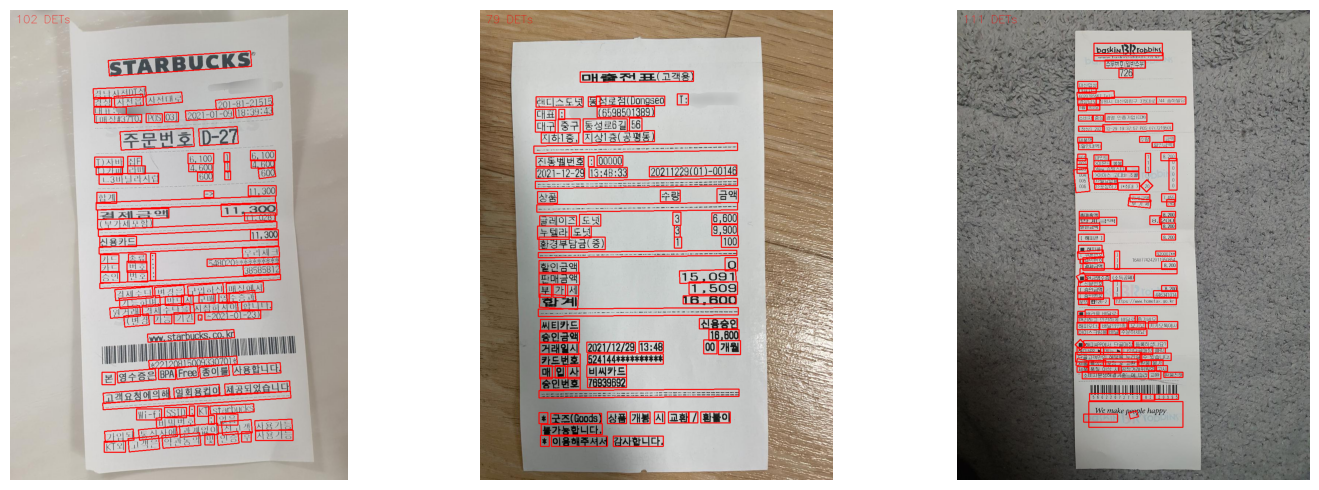

In [ ]:
#@title 추론 결과 후처리 및 시각화

# 시각화를 위한 메소드
def draw_boxes(image, det_polys, det_color=(0, 0, 255), thickness=2):
    # Draw Detected Polygons
    cv2.putText(image, f"{len(det_polys)} DETs",
                (15, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, det_color)
    for box in det_polys:
        box = np.array(box).reshape(-1, 2).astype(np.int32)
        cv2.polylines(image, [box], True, det_color, thickness=thickness)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


# 후처리 실행
post_processor = DBPostProcessor()
result_images = []
for idx, data in enumerate(batch):
    boxes_batch, scores_batch = post_processor.represent(data, preds[idx])
    result_images.append(draw_boxes(data['origin_images'][0], boxes_batch[0]))


# 결과 시각화
# 이미지 수에 따라 행의 수 계산
n_rows = len(result_images) // 3 + int(len(result_images) % 3 > 0)

# 이미지 표시
plt.figure(figsize=(15, 5 * n_rows))
for i, image in enumerate(result_images):
    plt.subplot(n_rows, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()